In [292]:
# First let's import the packages we will use in this project
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import matplotlib
# Set the plotting style to 'ggplot' for a clean, professional look with grid background
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib.patches import Patch
import scipy.stats as sci


# Enable inline plotting so that plots appear directly in the notebook output
%matplotlib inline
# Set the default figure size to 12 inches wide by 8 inches tall for all plots
matplotlib.rcParams['figure.figsize'] = (12,8)

# Disable the SettingWithCopyWarning to avoid false positive warnings when modifying DataFrames
pd.options.mode.chained_assignment = None
# Configure pandas to display all rows in DataFrame outputs by default
pd.set_option('display.max_rows', None)

In [262]:
#variables for column names
alcohol_liters_per_capita = "alcohol_liters_per_capita"

In [263]:
df = pd.read_csv("who_alcohol.csv")
df.head(10)

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode
0,Italy,ITA,2003,Both sexes,9.622988,7.965011,11.388622,3.423611,SA_0000001688
1,"Tanzania, United Republic of",TZA,2006,Both sexes,6.337646,4.767623,8.109324,3.341701,SA_0000001688
2,Cyprus,CYP,2017,Both sexes,6.117152,4.627244,7.798063,3.170819,SA_0000001688
3,Sierra Leone,SLE,2019,Both sexes,0.253228,0.100851,0.567434,0.466583,SA_0000001688
4,Philippines,PHL,2017,Both sexes,6.023875,4.681733,7.536645,2.854912,SA_0000001688
5,Qatar,QAT,2007,Both sexes,1.172084,0.612613,1.854674,1.242061,SA_0000001688
6,Pakistan,PAK,2018,Both sexes,0.104081,0.036438,0.340114,0.303676,SA_0000001688
7,Andorra,AND,2005,Both sexes,13.008124,11.013494,14.829454,3.815960,SA_0000001688
8,Slovenia,SVN,2000,Both sexes,12.477747,10.599043,14.375460,3.776417,SA_0000001688
9,Maldives,MDV,2009,Both sexes,1.963434,0.535407,3.335924,2.800517,SA_0000001688


As we can see, every country has one row for each year between 2000 and 2022 inclusive. 

Let's check for any missing values

In [264]:
# Calculate % of missing values per column. np.mean() on boolean Series (True=1, False=0) gives proportion of True values. Sums number of True (1) and divides by total count

for col in df.columns:
    pct = np.mean(df[col].isnull())
    print(f"{pct * 100}%")


0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%


There are no missing values within the data. 

Let's convert alcohol_liters_per_capita into a more readable and easily understood form.

Let's convert it to units_per_capita_week (UK Units = 10ml Pure alcohol)
Let's also add a percentage of the UK low-risk guideline consumed per week (14 units)

In [265]:
df["units_per_capita_week"] = round(df["alcohol_liters_per_capita"] * 100 / 52, ndigits=1)
df["perc_uk_guideline"] = round(df["units_per_capita_week"] / 14 * 100, ndigits=1)
df.sort_values(by="units_per_capita_week", ascending=False).head()

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
1027,Romania,ROU,2002,Both sexes,19.497715,16.902455,22.251088,5.348633,SA_0000001688,37.5,267.9
3019,Romania,ROU,2003,Both sexes,19.389771,16.643855,22.116943,5.473088,SA_0000001688,37.3,266.4
803,Romania,ROU,2000,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1856,Romania,ROU,2001,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1768,Romania,ROU,2004,Both sexes,18.639676,15.787315,21.476058,5.688743,SA_0000001688,35.8,255.7


Let's begin analysing.

### Question 1: Are global alcohol consumption levels trending upward or downward overall?

In [266]:
#finds average consumption per person per year
yearly = df.groupby("year")["alcohol_liters_per_capita"].aggregate('mean')
#convert year index into an explicit column
yearly = yearly.reset_index()


In [267]:
#find global percentage change
g_cons = yearly["alcohol_liters_per_capita"].to_numpy()

#percent change globally between 2000 and 2022
global_change = float(round((g_cons[-1] - g_cons[0]) / g_cons[0] * 100, 1))
global_change

-3.0

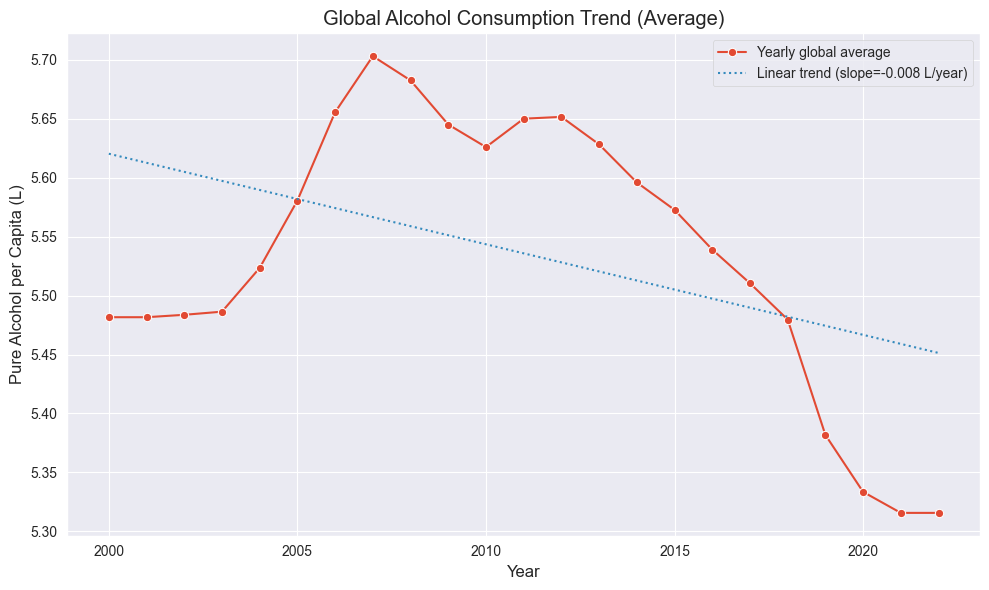

In [268]:
x = yearly["year"]
y = yearly["alcohol_liters_per_capita"]


#np.polyfit() finds best-fitting polynomial curve through data points: y ≈ m*x + c
#degree=1 means "a straight line"
m, c = np.polyfit(x, y, 1)

# This creates the function y = m*x + c
f = np.poly1d([m, c]) #takes a list of coefficients in descending order of polynomial degree
y_best_fit = f(x) # computes y values for all x values


sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plot the actual yearly global averages as a line chart
sns.lineplot(
    data=yearly,
    x=x,
    y=y,
    marker="o", # show dots at each year
    label="Yearly global average"
)

# Overlay the regression line
plt.plot(
    x,
    y_best_fit,
    linestyle=":",
    label=f"Linear trend (slope={m:.3f} L/year)"
)

# Add titles and axis labels so the plot is self-explanatory (portfolio essential)
plt.title("Global Alcohol Consumption Trend (Average)")
plt.xlabel("Year")
plt.ylabel("Pure Alcohol per Capita (L)")
plt.legend()
plt.tight_layout()


Global alcohol consumption levels have been decreasing since 2012 worldwide, -3% between 2000 and 2022 

This is shown by the consistent downwards-sloping trend line in the yearly global average.

The flattening near the end of the graph suggests that global per-capita alcohol consumption has stabilised in the past 3 years.

This suggests that in the long-term, there would limited benefit in relying on global increases in alcohol consumption, emphasising the importance of targeting specific countries that show stronger and more reliable long-term trends.  




### Question 2: Which countries have experienced the largest increases or decreases in alcohol consumption since 2000?


In [269]:
base_2000s = df[df["year"] == 2000]
base_2000s.rename(columns={"alcohol_liters_per_capita":"base_consumption"}, inplace=True)
#join the base 2000s with the original dataframe so that every row now stores what it had in 2000
mdf_2000 = df.merge(right=base_2000s, on="country", how="left")
mdf_2000["per_change"] = round((mdf_2000["alcohol_liters_per_capita"] - mdf_2000["base_consumption"]) / mdf_2000["base_consumption"] * 100)

#remove any country where the starting and ending consumption is less than 1. Removes most widely religious countries where alcohol isn't really consumed at all
mdf_2000 = mdf_2000[(mdf_2000["base_consumption"] >= 1) & (mdf_2000["alcohol_liters_per_capita"] >= 1)]

#decides top x to show 
x_biggest_changes = 3


In [270]:
biggest_increases = (
    mdf_2000
    [mdf_2000["year_x"] == 2022]
    .sort_values(by="per_change", ascending=False)
    .head(x_biggest_changes)
    .reset_index()
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]

 )
biggest_increases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,Mongolia,2.760842,7.735525,180.0
1,Viet Nam,4.046239,10.715408,165.0
2,Congo,2.718459,6.351449,134.0


In [271]:
biggest_decreases = (
    mdf_2000
    [mdf_2000["year_x"] == 2022]
    .sort_values(by="per_change", ascending=True)
    .reset_index()
    .head(x_biggest_changes)
    [["country", "base_consumption", "alcohol_liters_per_capita", "per_change"]]
 )

biggest_decreases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,"Venezuela, Bolivarian Republic of",8.240533,2.339490,-72.0
1,Burkina Faso,17.475384,7.457268,-57.0
2,Bahrain,2.725937,1.660289,-39.0


Many countries will not be considered in order to make this analysis meaningful.
For instance:
* Yemen ranked first in largest increase. Alcohol is largely illegal in Yemen since over 99% of Yemen's population is Muslim
* 91-97% of Sudan is Sunni Muslim
* 97-99% of Libya is Muslim

In [272]:
#Plotting
#filter mdf_2000 to only contain the countries within biggest_increses and biggest_decreases

inc_x = mdf_2000[mdf_2000["country"].isin(biggest_increases["country"])]
inc_x.sort_values(by=["country", "year_x"], inplace=True)

dec_x = mdf_2000[mdf_2000["country"].isin(biggest_decreases["country"])]
dec_x.sort_values(by=["country", "year_x"], inplace=True)
dec_x.head(5)

,country,iso3_x,year_x,sex_x,alcohol_liters_per_capita,lower_ci_x,upper_ci_x,ci_width_x,IndicatorCode_x,units_per_capita_week_x,...,year_y,sex_y,base_consumption,lower_ci_y,upper_ci_y,ci_width_y,IndicatorCode_y,units_per_capita_week_y,perc_uk_guideline_y,per_change
832,Bahrain,BHR,2000,Both sexes,2.725937,1.761890,3.720094,1.958204,SA_0000001688,5.2,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,0.0
2363,Bahrain,BHR,2001,Both sexes,2.725937,1.761890,3.720094,1.958204,SA_0000001688,5.2,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,0.0
636,Bahrain,BHR,2002,Both sexes,2.597726,1.713092,3.537848,1.824757,SA_0000001688,5.0,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-5.0
2235,Bahrain,BHR,2003,Both sexes,2.485934,1.669698,3.452146,1.782448,SA_0000001688,4.8,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-9.0
989,Bahrain,BHR,2004,Both sexes,2.323123,1.468591,3.246961,1.778370,SA_0000001688,4.5,...,2000,Both sexes,2.725937,1.76189,3.720094,1.958204,SA_0000001688,5.2,37.1,-15.0


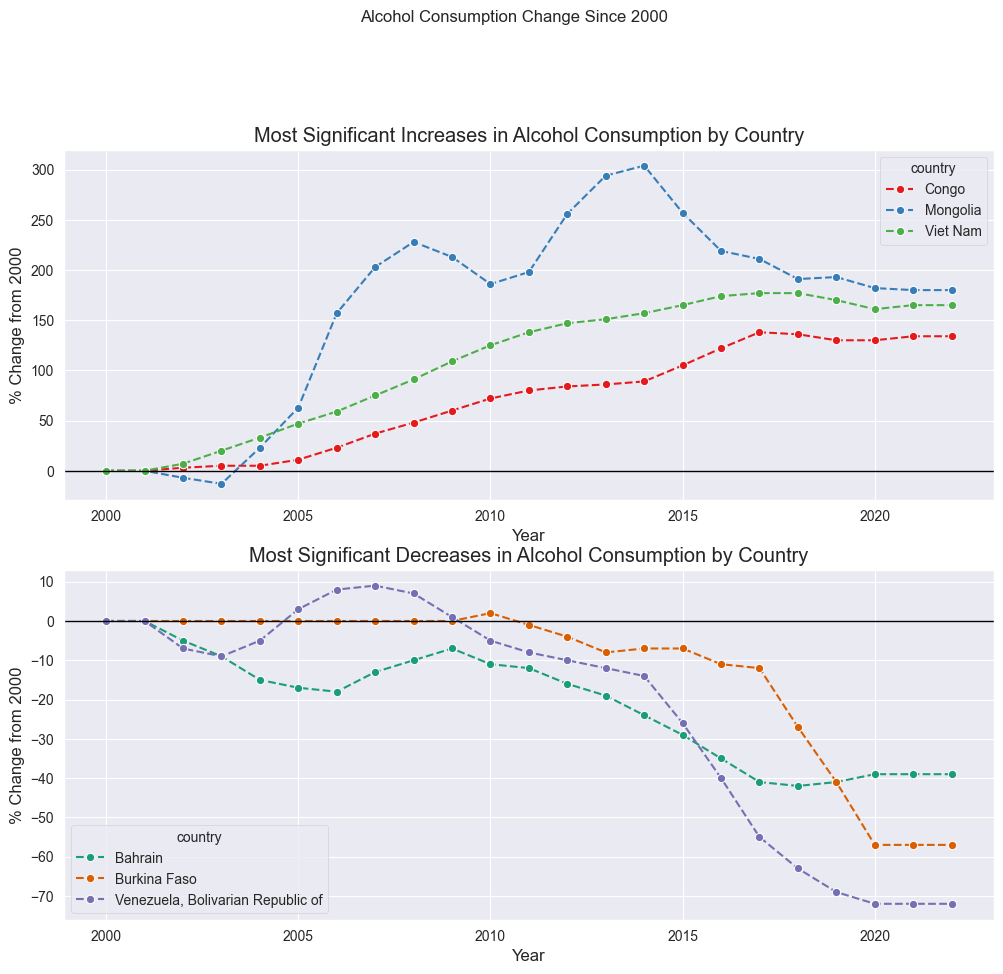

In [273]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
sns.lineplot(
    data=inc_x,
    y="per_change",
    x="year_x",
    hue="country",
    ax=axes[0],
    palette="Set1",
    linestyle="--",
    marker="o" # show dots at each year

)

sns.lineplot(
    data=dec_x,
    y="per_change",
    x="year_x",
    hue="country",
    ax=axes[1],
    palette="Dark2",
    linestyle="--",#
    marker="o" # show dots at each year
)


axes[0].axhline(0, color="black", linewidth=1)
axes[1].axhline(0, color="black", linewidth=1)

axes[0].set_title("Most Significant Increases in Alcohol Consumption by Country")
axes[1].set_title("Most Significant Decreases in Alcohol Consumption by Country")

fig.suptitle("Alcohol Consumption Change Since 2000", y=1.02)



biggest_labels = ["Year", "% Change from 2000"]
axes[0].set_xlabel(biggest_labels[0])
axes[0].set_ylabel(biggest_labels[1])
axes[1].set_xlabel(biggest_labels[0])
axes[1].set_ylabel(biggest_labels[1])

#optional legend styling
    # for ax in axes:
    #     ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    # Adjust subplot spacing within the figure:
    # rect=(left, bottom, right, top) are fractions of the figure size (0 to 1).
    # Here we shrink the usable plotting area to 82% width (right=0.82) to leave space for the legends.
    # fig.tight_layout(rect=(0, 1, 1, 1))
plt.show()


In [274]:
biggest_increases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,Mongolia,2.760842,7.735525,180.0
1,Viet Nam,4.046239,10.715408,165.0
2,Congo,2.718459,6.351449,134.0


In [275]:
biggest_decreases

,country,base_consumption,alcohol_liters_per_capita,per_change
0,"Venezuela, Bolivarian Republic of",8.240533,2.339490,-72.0
1,Burkina Faso,17.475384,7.457268,-57.0
2,Bahrain,2.725937,1.660289,-39.0


Better:

Answer: 
Mongolia, Vietnam, and Congo show the largest increases in alcohol consumption since 2000, with Mongolia exhibiting the strongest sustained upward trend over time.

Evidence: 
This is reflected in consistently higher per-capita consumption levels in Mongolia relative to the other high-growth countries across most years since the mid-2000s, alongside a clear long-term upward trajectory.

Implication: 
These patterns indicate that alcohol consumption has grown substantially in these markets despite the overall global decline, suggesting country-specific drivers of demand rather than global trends alone.

Actionable insight: 
Mongolia and Vietnam, in particular, warrant further market-level analysis as potential expansion targets due to their sustained and relatively stable growth in alcohol consumption over the past two decades.
  

### Question 3: How consistent is alcohol consumption within countries over time?


In [276]:
vol = (
    df
    .groupby("country")["alcohol_liters_per_capita"]
    .std()
    .reset_index()
    .rename(columns={"alcohol_liters_per_capita": "std"})
    .sort_values("std", ascending=False)
    .reset_index(drop=True)
)
vol.head(10)

,country,std
0,Burkina Faso,3.559911
1,Mongolia,2.730455
2,Viet Nam,2.612829
3,"Venezuela, Bolivarian Republic of",2.427491
4,Cambodia,1.870162
5,Russian Federation,1.747416
6,Namibia,1.636941
7,China,1.511431
8,Angola,1.472944
9,Ukraine,1.451018


C:\Users\huang_pc\AppData\Local\Temp\ipykernel_16092\2069955794.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  con_ax = sns.barplot(


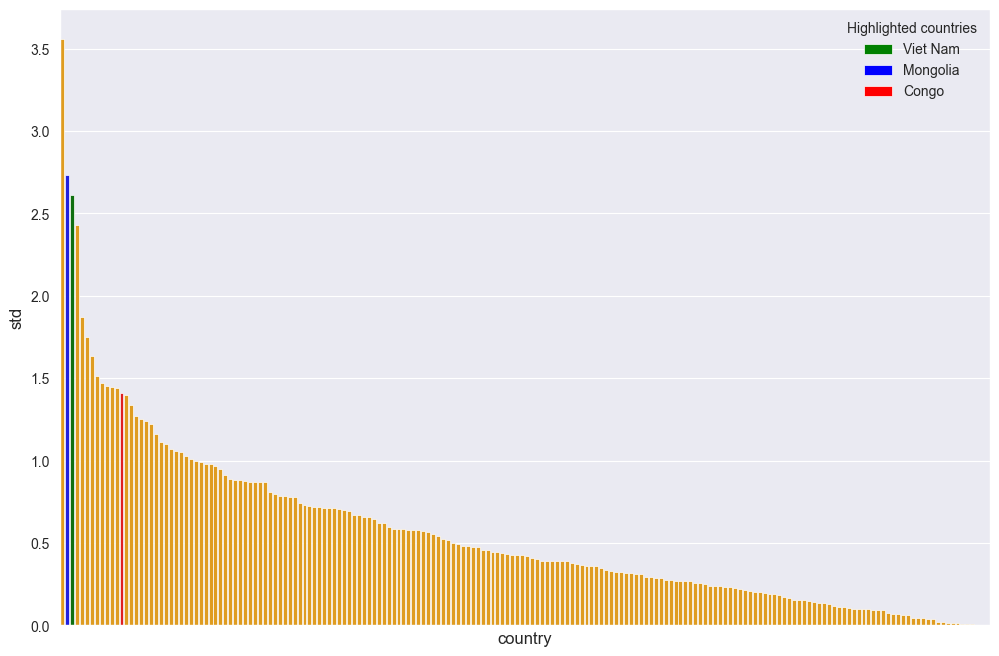

In [277]:
#highlight countries with largest increase in consumption from before

top_inc_dict = {
    "Viet Nam": "green",
    "Mongolia": "blue",
    "Congo": "red"
    
}

pal_top_inc = {
    c: (top_inc_dict[c] if c in top_inc_dict else "orange") for c in vol["country"]
    }




con_ax = sns.barplot(
    data=vol,
    x="country",
    y="std",
    palette=pal_top_inc
)

con_ax.tick_params(axis="x", labelbottom=False)

handles = [Patch(facecolor=color, label=country) for country, color in top_inc_dict.items()]
con_ax.legend(handles=handles, title="Highlighted countries", frameon=False, loc="upper right")

Point

The 3 countries with the largest increase in alcohol consumption have a high variability in consumption for any given year.

Evidence

Mongolia, Vietnam and Congo rank in the top 15 least consistent countries for alcohol consumption, which is influenced by the fact that their consumption has increased substantially.

Explain

This indicates that these countries could continue to have significant changes in average consumption per year, suggesting caution and further analysis for suitability. 

In [278]:
vol[vol["country"] == "Congo"]

,country,std
12,Congo,1.408829


In [279]:
#show a graph of the top 5 most consistent countries that also drink quite a lot of alcohol. 
#there needs to be some sort of compromise / trade-off i decide for consistency vs amount they drink
#a slightly less consistent country that drinks a lot is better than the most consistent country but low consumption
avg_cons_country = (
    df
    .groupby("country")
    [["alcohol_liters_per_capita"]]
    .aggregate("mean")
    .reset_index()
)

m_vol_con = vol.merge(avg_cons_country, on="country")
m_vol_con.sort_values(by="alcohol_liters_per_capita", ascending=False, inplace=True)
m_vol_con[m_vol_con["std"] <= 0.5].head(10)

,country,std,alcohol_liters_per_capita
89,Czechia,0.438490,14.023567
87,Austria,0.442873,12.351127
79,Slovenia,0.499935,11.657066
108,Slovakia,0.358106,11.457966
94,Bulgaria,0.421421,11.104860
119,Australia,0.290908,10.923598
126,Canada,0.267290,9.975901
125,New Zealand,0.270089,9.575981
153,Sweden,0.135090,9.509617
124,United States,0.271785,9.223502


C:\Users\huang_pc\AppData\Local\Temp\ipykernel_16092\1793805567.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  con_ax = sns.barplot(


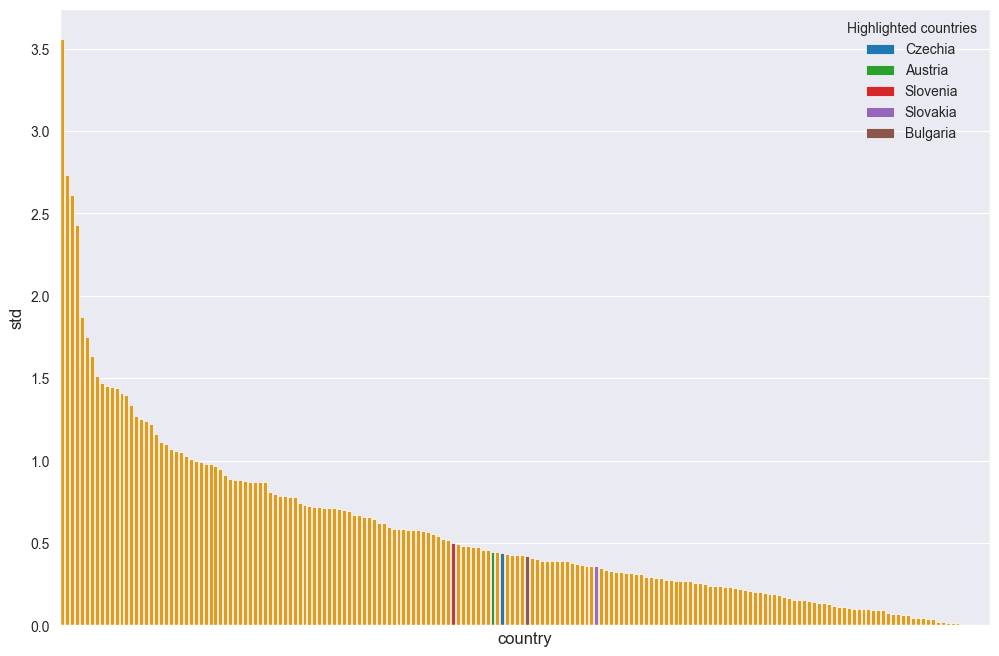

In [280]:
top_consistent_colors = {
    "Czechia": "tab:blue",
    "Austria": "tab:green",
    "Slovenia": "tab:red",
    "Slovakia": "tab:purple",
    "Bulgaria": "tab:brown",
}

pal_top_inc = {
    c: (top_consistent_colors[c] if c in top_consistent_colors else "orange") for c in vol["country"]
    }




con_ax = sns.barplot(
    data=vol,
    x="country",
    y="std",
    palette=pal_top_inc
)

con_ax.tick_params(axis="x", labelbottom=False)

handles = [Patch(facecolor=color, label=country) for country, color in top_consistent_colors.items()]
con_ax.legend(handles=handles, title="Highlighted countries", frameon=False, loc="upper right")

In [281]:
consistant_and_volume = m_vol_con[m_vol_con["std"] <= 0.5]
consistant_and_volume.head(5)

,country,std,alcohol_liters_per_capita
89,Czechia,0.438490,14.023567
87,Austria,0.442873,12.351127
79,Slovenia,0.499935,11.657066
108,Slovakia,0.358106,11.457966
94,Bulgaria,0.421421,11.104860


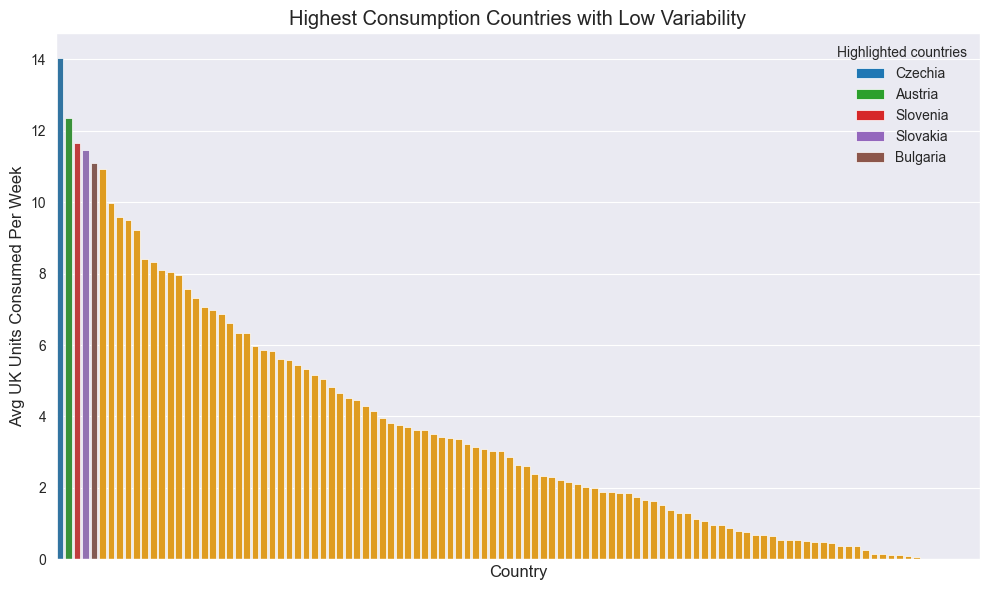

In [282]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))


con_ax = sns.barplot(
    data=consistant_and_volume,
    x="country",
    y="alcohol_liters_per_capita",
    legend="auto",
    palette=pal_top_inc,
    hue="country",
)
plt.title("Highest Consumption Countries with Low Variability")
plt.xlabel("Country")
plt.ylabel("Avg UK Units Consumed Per Week")

con_ax.tick_params(axis="x", labelbottom=False)

handles = [Patch(facecolor=color, label=country) for country, color in top_consistent_colors.items()]
con_ax.legend(handles=handles, title="Highlighted countries", frameon=False, loc="upper right")



plt.tight_layout()

In [283]:
df.sort_values(by="units_per_capita_week").head()

#for every liter of alcohol drunk per year, this equates to around 2 Uk units per week

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
34,Yemen,YEM,2004,Both sexes,0.000000,0.0,0.000000,0.000000,SA_0000001688,0.0,0.0
746,Somalia,SOM,2007,Both sexes,0.000000,0.0,0.000000,0.000000,SA_0000001688,0.0,0.0
1987,Sudan,SDN,2005,Both sexes,0.000197,0.0,0.011413,0.011413,SA_0000001688,0.0,0.0
3006,Afghanistan,AFG,2004,Both sexes,0.010079,0.0,0.095442,0.095442,SA_0000001688,0.0,0.0
4070,Yemen,YEM,2021,Both sexes,0.000148,0.0,0.009939,0.009939,SA_0000001688,0.0,0.0


#### Question 4 (make earlier): How have regional alcohol consumption patterns evolved over time, and which regions are becoming more or less attractive markets? 

In [284]:
#map countries to continent (ai generated)
country_continent = {
    # Africa
    "Algeria": "Africa",
    "Angola": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Burundi": "Africa",
    "Cameroon": "Africa",
    "Cabo Verde": "Africa",
    "Central African Republic": "Africa",
    "Chad": "Africa",
    "Comoros": "Africa",
    "Congo": "Africa",
    "Congo, The Democratic Republic of the": "Africa",
    "Côte d'Ivoire": "Africa",
    "Djibouti": "Africa",
    "Egypt": "Africa",
    "Equatorial Guinea": "Africa",
    "Eritrea": "Africa",
    "Ethiopia": "Africa",
    "Gabon": "Africa",
    "Gambia": "Africa",
    "Ghana": "Africa",
    "Guinea": "Africa",
    "Guinea-Bissau": "Africa",
    "Kenya": "Africa",
    "Lesotho": "Africa",
    "Liberia": "Africa",
    "Libya": "Africa",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania": "Africa",
    "Mauritius": "Africa",
    "Morocco": "Africa",
    "Mozambique": "Africa",
    "Namibia": "Africa",
    "Niger": "Africa",
    "Nigeria": "Africa",
    "Rwanda": "Africa",
    "Senegal": "Africa",
    "Sierra Leone": "Africa",
    "Somalia": "Africa",
    "South Africa": "Africa",
    "South Sudan": "Africa",
    "Sudan": "Africa",
    "Togo": "Africa",
    "Tunisia": "Africa",
    "Tanzania, United Republic of": "Africa",
    "Uganda": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Sao Tome and Principe":"Africa",
    "Eswatini":"Africa",
    "Seychelles":"Africa",
    
    # Asia
    "Afghanistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Bahrain": "Asia",
    "Bangladesh": "Asia",
    "Bhutan": "Asia",
    "Brunei Darussalam": "Asia",
    "Cambodia": "Asia",
    "China": "Asia",
    "Hong Kong": "Asia",
    "India": "Asia",
    "Indonesia": "Asia",
    "Iran, Islamic Republic of": "Asia",
    "Iraq": "Asia",
    "Israel": "Asia",
    "Japan": "Asia",
    "Jordan": "Asia",
    "Kazakhstan": "Asia",
    "Korea, Democratic People's Republic of": "Asia",
    "Korea, Republic of": "Asia",
    "Kuwait": "Asia",
    "Kyrgyzstan": "Asia",
    "Lao People's Democratic Republic": "Asia",
    "Lebanon": "Asia",
    "Maldives": "Asia",
    "Malaysia": "Asia",
    "Mongolia": "Asia",
    "Myanmar": "Asia",
    "Nepal": "Asia",
    "Oman": "Asia",
    "Pakistan": "Asia",
    "Palestine": "Asia",
    "Philippines": "Asia",
    "Qatar": "Asia",
    "Saudi Arabia": "Asia",
    "Singapore": "Asia",
    "Sri Lanka": "Asia",
    "Syrian Arab Republic": "Asia",
    "Tajikistan": "Asia",
    "Thailand": "Asia",
    "Timor-Leste": "Asia",
    "Türkiye": "Asia",
    "Turkmenistan": "Asia",
    "United Arab Emirates": "Asia",
    "Uzbekistan": "Asia",
    "Viet Nam": "Asia",
    "West Bank and Gaza Strip": "Asia",
    "Yemen": "Asia",
    
    # Europe
    "Albania": "Europe",
    "Andorra": "Europe",
    "Austria": "Europe",
    "Belarus": "Europe",
    "Belgium": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Bulgaria": "Europe",
    "Croatia": "Europe",
    "Cyprus": "Europe",
    "Czechia": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Estonia": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Georgia": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Iceland": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Kosovo": "Europe",
    "Latvia": "Europe",
    "Liechtenstein": "Europe",
    "Lithuania": "Europe",
    "Luxembourg": "Europe",
    "Malta": "Europe",
    "Moldova, Republic of": "Europe",
    "Monaco": "Europe",
    "Montenegro": "Europe",
    "Netherlands": "Europe",
    "North Macedonia": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Serbia": "Europe",
    "Romania": "Europe",
    "Russian Federation": "Europe",
    "San Marino": "Europe",
    "Slovakia": "Europe",
    "Slovenia": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Ukraine": "Europe",
    "United Kingdom": "Europe",
    
    # North America
    "Antigua and Barbuda": "North America",
    "Bahamas": "North America",
    "Barbados": "North America",
    "Belize": "North America",
    "Canada": "North America",
    "Costa Rica": "North America",
    "Cuba": "North America",
    "Dominica": "North America",
    "Dominican Republic": "North America",
    "El Salvador": "North America",
    "Grenada": "North America",
    "Guatemala": "North America",
    "Haiti": "North America",
    "Honduras": "North America",
    "Jamaica": "North America",
    "Mexico": "North America",
    "Nicaragua": "North America",
    "Panama": "North America",
    "Saint Kitts and Nevis": "North America",
    "Saint Lucia": "North America",
    "Saint Vincent and the Grenadines": "North America",
    "Trinidad and Tobago": "North America",
    "United States": "North America",
    
    # South America
    "Argentina": "South America",
    "Bolivia, Plurinational State of": "South America",
    "Brazil": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Ecuador": "South America",
    "Guyana": "South America",
    "Paraguay": "South America",
    "Peru": "South America",
    "Suriname": "South America",
    "Uruguay": "South America",
    "Venezuela, Bolivarian Republic of": "South America",
    
    # Oceania
    "Australia": "Oceania",
    "Fiji": "Oceania",
    "Kiribati": "Oceania",
    "Micronesia, Federated States of": "Oceania",
    "Nauru": "Oceania",
    "New Zealand": "Oceania",
    "Niue": "Oceania",
    "Palau": "Oceania",
    "Papua New Guinea": "Oceania",
    "Samoa": "Oceania",
    "Solomon Islands": "Oceania",
    "Tonga": "Oceania",
    "Tuvalu": "Oceania",
    "Vanuatu": "Oceania",
}

In [285]:
df["continent"] = df["country"].map(country_continent)
df[df["continent"].isna()]

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline,continent


In [286]:
#create a pivot table of year against continent where the values are the average alcohol consumption for that continent in that year
cons_by_continent = df.pivot_table(
    values=alcohol_liters_per_capita,
    index="year",
    columns="continent",
    aggfunc="mean"
)

cons_by_continent.head()

continent,Africa,Asia,Europe,North America,Oceania,South America
year,,,,,,
2000,3.697727,2.487627,11.042921,6.001467,3.671890,5.987217
2001,3.697727,2.487627,11.042921,6.001467,3.671890,5.987217
2002,3.688321,2.502589,11.047760,6.031773,3.691464,5.910576
2003,3.679257,2.506960,11.082853,6.089840,3.532243,5.915311
2004,3.689373,2.567858,11.116114,6.164615,3.497235,6.006426


In [287]:
cons_by_continent = (
    cons_by_continent
    .reset_index()
    .melt(
        id_vars="year",
        var_name="continent",
        value_name="consumption"
    )
)

cons_by_continent.head()

,year,continent,consumption
0,2000,Africa,3.697727
1,2001,Africa,3.697727
2,2002,Africa,3.688321
3,2003,Africa,3.679257
4,2004,Africa,3.689373


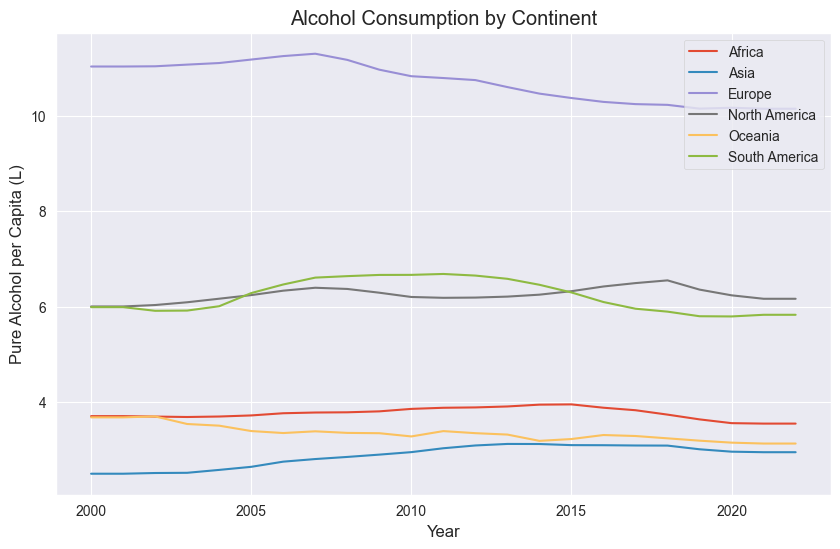

In [288]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=cons_by_continent,
    x="year",
    y="consumption",
    hue="continent"
)

plt.title("Alcohol Consumption by Continent")
plt.xlabel("Year")
plt.ylabel("Pure Alcohol per Capita (L)")
plt.legend()
# plt.tight_layout()

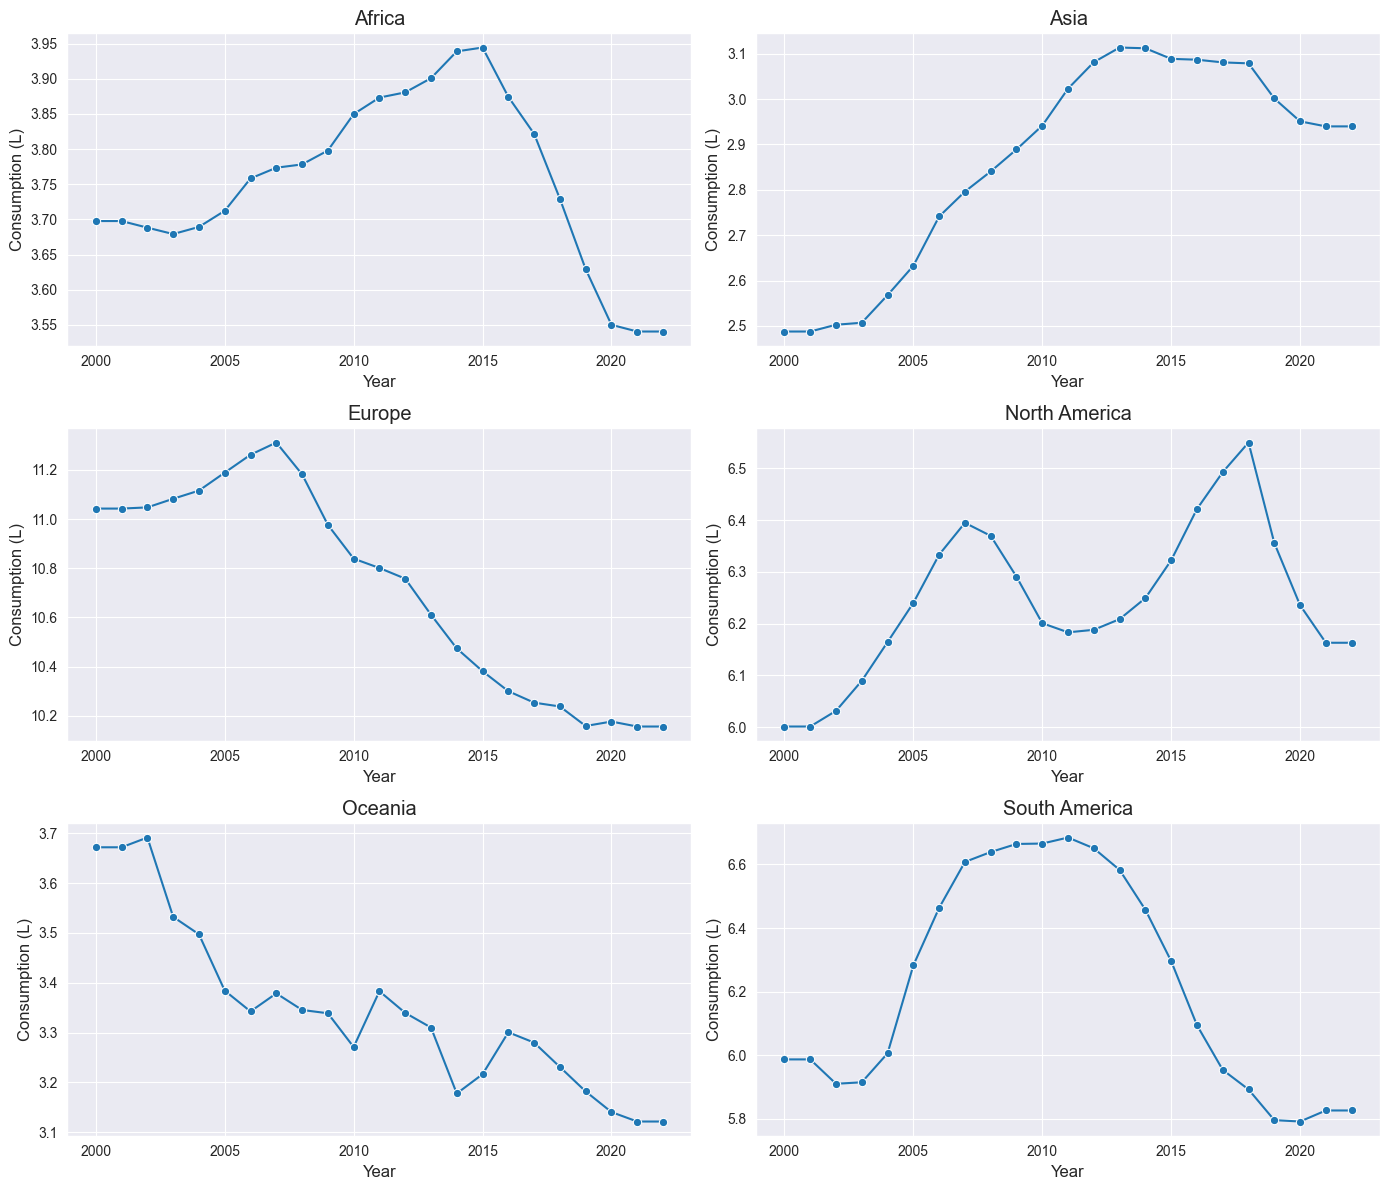

In [289]:
sns.set_style("darkgrid")

# Get unique continents
continents = cons_by_continent["continent"].unique()
n_continents = len(continents)

# Create subplots (adjust rows/cols as needed)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten to make iteration easier

# Plot each continent
for i, continent in enumerate(continents):
    # Filter data for this continent
    continent_data = cons_by_continent[cons_by_continent["continent"] == continent]
    
    sns.lineplot(
        data=continent_data,
        x="year",
        y="consumption",
        ax=axes[i],
        marker="o",
        color="tab:blue"
    )
    
    axes[i].set_title(f"{continent}")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Consumption (L)")

# Hide any extra subplots if you have more subplots than continents
for i in range(n_continents, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

#### Question 5: Do countries with higher average alcohol consumption also show greater year-to-year volatility in consumption?

In [290]:
m_vol_con.head(10)



,country,std,alcohol_liters_per_capita
36,Romania,0.880432,17.787166
0,Burkina Faso,3.559911,15.302122
20,Georgia,1.112764,14.338525
89,Czechia,0.438490,14.023567
16,Lithuania,1.250769,13.069003
5,Russian Federation,1.747416,13.036055
26,France,1.009775,12.929060
22,Latvia,1.070645,12.766684
21,Hungary,1.101060,12.506658
11,Ireland,1.441809,12.431887


Text(0.5, 1.0, 'Consumption vs Volatility\n(Correlation: r=0.709, p=0.0000)')

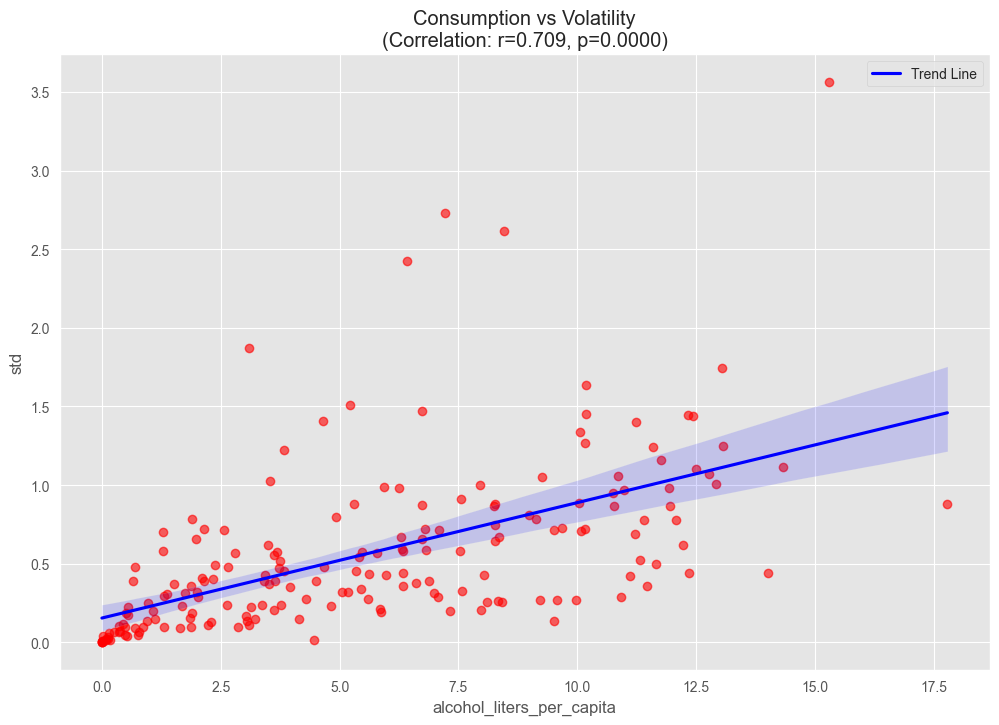

In [293]:
r, p_value = sci.spearmanr(m_vol_con[alcohol_liters_per_capita], m_vol_con["std"])

sns.regplot(
    data=m_vol_con,
    x=alcohol_liters_per_capita,
    y="std",
    scatter_kws={"color":"red", "alpha":0.6},
    line_kws={"color":"blue", "label":f"Trend Line"},
)
plt.legend()
plt.title(f"Consumption vs Volatility\n(Correlation: r={r:.3f}, p={p_value:.4f})")